In [ ]:
from comet_ml import API
import comet_ml
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import time

In [ ]:
comet_api = API(rest_api_key='6O55PoJt4tkp9LyupIE86eikH')
comet_api.get()


In [ ]:
def get_parameter_by_key(exp, key):
    parameters = exp.get_parameters_summary()
    for parameter in parameters:
        if parameter['name'] == key:
            return parameter['valueCurrent']
    return None

In [ ]:
def get_parameter_by_key(exp, key):
    parameters = exp.get_parameters_summary()
    for parameter in parameters:
        if parameter['name'] == key:
            return parameter['valueCurrent']
    return None

def new_to_old_metric(exp, key):
    metric = exp.get_metrics(key)
    vals = [float(m['metricValue']) for m in metric]
    return vals

def stack_lists(data, n=1000):
    new_data = []
    for d in data:
        if len(d) > n:
            new_data.append(d[:n])
        elif len(d) < n:
            new_data.append(
                np.concatenate([d, d[-1].repeat(n - len(d))])
            )
    return np.vstack(new_data).T

def preprocess_gp(vals):
    return np.minimum.accumulate(vals)

def add_zero_point(vals, point):
    return np.array([point] + vals.tolist())

In [ ]:
experiments = comet_api.get(workspace='schattengenie', project_name='em-showers-network-clustering-new')

In [ ]:
exp = experiments[0]

In [ ]:
from collections import defaultdict

data = defaultdict(lambda: defaultdict(list))
for exp in experiments:
    good_showers = new_to_old_metric(exp, "Good showers")
    if len(good_showers):
        threshold = float(exp.get_command()[-5])
        min_samples_core = int(get_parameter_by_key(exp, "min_samples_core"))
        data[threshold][min_samples_core].append(good_showers[0])

In [ ]:
threshold_data = defaultdict(list)
quality_data = defaultdict(list)
quality_std_data = defaultdict(list)

for threshold in data:
    for min_samples_core in data[threshold]:
        q = data[threshold][min_samples_core]
        threshold_data[min_samples_core].append(threshold)
        quality_data[min_samples_core].append(np.mean(q))
        quality_std_data[min_samples_core].append(np.std(q))

In [ ]:
sns.set(context='paper', style="whitegrid", font_scale=3, font = 'serif')
colors = [
    'skyblue', 'orange', 'steelblue', 'gold', '#f58231', 
]
%matplotlib inline
linewidth = 3



In [ ]:
def plot_mean_std(idx, mean, std, label="", i=0):
    idx = np.array(idx)
    mean = np.array(mean)
    std = np.array(std)
    upper = mean + std
    lower = mean - std
    plt.plot(idx, mean, c=colors[i], linewidth=linewidth, label=label, zorder=5)
    plt.plot(idx, upper, 'b--', c=colors[i], zorder=5)
    plt.plot(idx, lower, 'b--', c=colors[i], zorder=5)
    plt.fill_between(idx, lower, upper, alpha=0.2, color=colors[i], zorder=5)

In [ ]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title("")
for i, min_samples_core in enumerate(threshold_data):
    plot_mean_std(threshold_data[min_samples_core], quality_data[min_samples_core], 
                  quality_std_data[min_samples_core], label="min_samples_core={}".format(min_samples_core), i=i)
plt.ylabel("Good showers")
plt.xlabel("Threshold")
# plt.ylim
plt.legend(loc='upper right', fontsize='xx-large')
plt.savefig("threshold_grid_search_plot.pdf", bbox_inches='tight')
plt.show()

In [ ]:
num_epochs = 1500

experiments = comet_api.get(workspace='schattengenie', project_name='em-showers-network-training')
experiments_balanced = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '5'
]
experiments_emulsion = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '0'
]
experiments_edge = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '8'
]

In [ ]:
balanced_roc_auc = []
for exp in experiments_balanced:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    balanced_roc_auc.append(roc_auc_test)
balanced_roc_auc = stack_lists(balanced_roc_auc, num_epochs)


edge_roc_auc = []
for exp in experiments_edge:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    edge_roc_auc.append(roc_auc_test)
edge_roc_auc = stack_lists(edge_roc_auc, num_epochs)

emulsion_roc_auc = []
for exp in experiments_emulsion:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    emulsion_roc_auc.append(roc_auc_test)
emulsion_roc_auc = stack_lists(emulsion_roc_auc, num_epochs)

In [ ]:
def plot_roc_auc_test(data, label="", i=0):
    idx = np.arange(len(data))
    mean = data.mean(1)
    std = data.std(1) / np.sqrt(data.shape[1])
    upper = mean + std
    lower = mean - std
    plt.plot(idx, mean, c=colors[i], linewidth=linewidth, label=label, zorder=5)
    plt.plot(idx, upper, 'b--', c=colors[i], zorder=5)
    plt.plot(idx, lower, 'b--', c=colors[i], zorder=5)
    plt.fill_between(idx, lower, upper, alpha=0.2, color=colors[i], zorder=5)


In [ ]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title("")
plot_roc_auc_test(edge_roc_auc, i=1, label="Pure edge")
plot_roc_auc_test(emulsion_roc_auc, i=0, label="Pure emulsion")
plot_roc_auc_test(balanced_roc_auc, i=2, label="Mix")

plt.ylabel("Validation ROC-AUC")
plt.xlabel("Epochs")
# plt.ylim
plt.legend(loc='upper right', fontsize='xx-large')
plt.savefig("validation_roc_auc.pdf", bbox_inches='tight')
plt.show()

-------

In [5]:
import torch
import torch.nn as nn
from opera_tools import plot_graphx, DISTANCE, scattering_estimation_loss
import matplotlib.pyplot as plt

import networkx as nx

In [141]:
import matplotlib.colors as mcolors

In [6]:
datafile='clusters.pt'
clusters = torch.load(datafile)

In [8]:
len(clusters['clusters'])

189

In [181]:
clusters['graphx'].nodes(data = True)[0]['signal']

0

In [192]:
clusters['graphx'].graph['showers_data'][0]['numtracks']

317.0

In [222]:
Colors = []
for name, hex in matplotlib.colors.cnames.items():
    Colors.append(name)

In [225]:
colors_list = list(colors._colors_full_map.values())

In [224]:
len(Colors)

148

In [339]:
clrs = Colors + colors_list[100:152]

In [340]:
len(clrs)

200

In [341]:
def plot_graphx(graphx: nx.DiGraph, azim=-84, elev=10):
    """
    Function for plotting shower
    """
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Line3DCollection
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(context='paper', style="whitegrid", font_scale=2, font = 'serif')
    
    x0, y0, z0 = [], [], []
    sx, sy = [], []
    #Signal = []
    Tracks = [] 
    for _, node in graphx.nodes(data=True):
        x0.append(node['features']['SX'])
        y0.append(node['features']['SY'])
        z0.append(node['features']['SZ'])
        sx.append(node['features']['TX'])
        sy.append(node['features']['TY'])
        #Signal.append(node['signal'])
        
    for i in range(200):
        Tracks.append(int(graphx.graph['showers_data'][i]['numtracks']))
        
    x0, y0, z0 = np.array(x0), np.array(y0), np.array(z0)
    sx, sy = np.array(sx), np.array(sy)

    x1 = x0 + dZ * sx
    y1 = y0 + dZ * sy
    z1 = z0 + dZ
    
    start_points = np.array([z0, y0, x0]).T.reshape(-1, 3)
    end_points = np.array([z1, y1, x1]).T.reshape(-1, 3)

    lc_0 = Line3DCollection(list(zip(start_points[:Tracks[0]], end_points[:Tracks[0]])),
                            colors = ['blue'], alpha=0.9, lw=2)
    lc_last = Line3DCollection(list(zip(start_points[len(start_points)-Tracks[199]:], 
                                        end_points[len(start_points)-Tracks[199]:])),
                               colors = ['gold'], alpha=0.9, lw=2)
    


    fig = plt.figure(figsize=(15, 15))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    ax.add_collection3d(lc_0)
    ax.add_collection3d(lc_last)
        
    start = 0
    end = 0
    lc_list = []
    for i in range(198):
        start += Tracks[i]
        end = start + Tracks[i+1]
        #print(start, end)
        
        lc = Line3DCollection(list(zip(start_points[start:end], 
                                       end_points[start:end])),
                             colors = clrs[i], alpha=0.9, lw=2)
        
        ax.add_collection3d(lc)


    ax.set_xlabel("z")
    ax.set_ylabel("y")
    ax.set_zlabel("x") 
    ax.set_xlim(z0.min(), z1.max())
    ax.set_ylim(y0.min(), y1.max())
    ax.set_zlim(x0.min(), x1.max())
    
    plt.show()
    plt.savefig("graph_colored.pdf", bbox_inches='tight')

In [342]:
BT_Z_unique = np.array([     0.,   1293.,   2586.,   3879.,   5172.,   6465.,   7758.,
                          9051.,  10344.,  11637.,  12930.,  14223.,  15516.,  16809.,
                         18102.,  19395.,  20688.,  21981.,  23274.,  24567.,  25860.,
                         27153.,  28446.,  29739.,  31032.,  32325.,  33618.,  34911.,
                         36204.,  37497.,  38790.,  40083.,  41376.,  42669.,  43962.,
                         45255.,  46548.,  47841.,  49134.,  50427.,  51720.,  53013.,
                         54306.,  55599.,  56892.,  58185.,  59478.,  60771.,  62064.,
                         63357.,  64650.,  65943.,  67236.,  68529.,  69822.,  71115.,
                         72408.,  73701.])


BRICK_X_MIN = 0.
BRICK_X_MAX = 103000. # 10.3 cm
BRICK_Y_MIN = 0.
BRICK_Y_MAX = 128000. # 12.8 cm
SAFE_M = 3000.
dZ = 0.00205 # 0.0205 cm emulsion
DISTANCE = 1293.

kwargs = {'bins': 100, 'alpha': 0.8, 'normed': True}



In [343]:
from matplotlib import rcParams
rcParams['axes.labelpad'] = 20.0

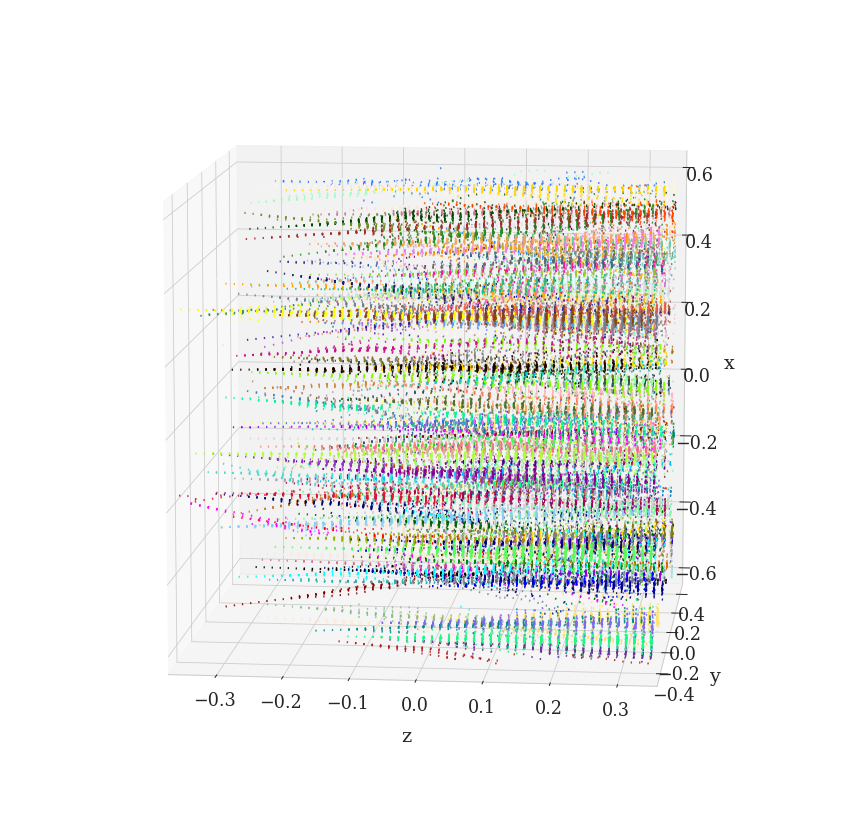

<Figure size 432x288 with 0 Axes>

In [344]:
plot_graphx((clusters['graphx']));